2017 : 구글 시퀀스 모델링을 위한 새로운 신경망
  - 기계번역에서 RNN을 능가
  - GPT
  - BERT

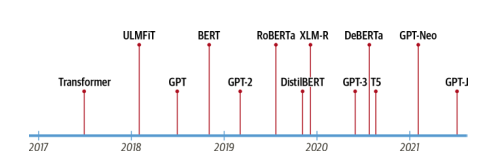

In [1]:
# 기초개념
# 인코더-디코더, 어텐션 매커니즘, 전이학습
# 허깅페이스 라이브러리

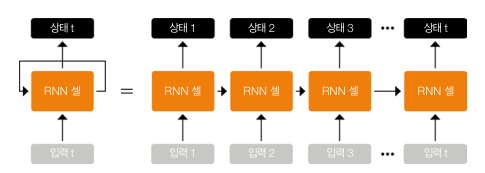

In [2]:
# RNN : 시퀀스를 한 언어에서 다른 언어로 매핑하는 기계번역 시스템
# 인코더-디코더, 시퀀스 투 시퀀스

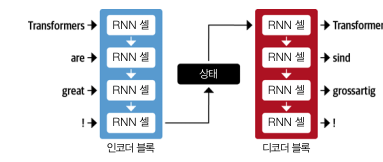

In [3]:
# 이 구조는 인코더의 마지막 은닉상태가 정보병목이 된다는 약점
# 마지막 상태를 가지고 디코더가 문장을 만들기 때문에 마지막상태는 모든 시퀀스를 포함 -> 시작 정보가 손실가능성이  있다
# 디코더가 모든 은닉상태에 접근해서 병목현상을 제거-> 어텐션 매커니즘

In [4]:
# 어텐션은 입력 시퀀스에서 은닉상태를 만들지 않고 스텝마다 인코더에서 디코더가 참고할 은닉상태를 출력 한다는 기본 개념

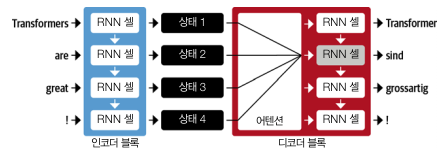

In [5]:
# 디코더가 모든 디코딩 타임스텝마다 인코더의 각 상태에 다른 가중치 또는 어텐션을 할당
# 태생적으로 계산이 순차적으로 이루어져서 입력 시퀀스 전체에 걸처 병렬화 할 수 없다
# 패러다음 변화, 순환을모두 없애고 셀프어텐션이라는 특별한형태의 어텐션

In [6]:
text = """Dear Amazon, last week I ordered an Optimus Prime action figure \
from your online store in Germany. Unfortunately, when I opened the package, \
I discovered to my horror that I had been sent an action figure of Megatron \
instead! As a lifelong enemy of the Decepticons, I hope you can understand my \
dilemma. To resolve the issue, I demand an exchange of Megatron for the \
Optimus Prime figure I ordered. Enclosed are copies of my records concerning \
this purchase. I expect to hear from you soon. Sincerely, Bumblebee."""

In [7]:
# 모든 단계를 추상화 할수 있는 파이프라인을 사용

In [8]:
!pip install transformers

In [9]:
from transformers import pipeline

In [10]:
# pipeline함수를 통해 관심작업에 대한 파이프라인 객체를 생성
classifier =  pipeline("text-classification")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [11]:
# 자동으로 허깅페이스제 접속해서 모델의 가중치를 다운로드
# 파이프라인을 다시 다운로드하면 ... 캐싱된 정보를 사용한다고 안내....
# text-classification  감성분석 -> 다중분류, 다중레이블 분류도 지원

In [12]:
# 텍스를 입력-->예측 리스트반환
outputs = classifier(text)
import pandas as pd
pd.DataFrame(outputs)

,label,score
0,NEGATIVE,0.901546


In [13]:
# 텍스트에서 개체명을 인식하는 작업
# 피드백이 특정 제품과 서비스중 무엇에 대한?
# NLP에서는 제품,장소, 사람같은 실제 객체를 개체명(named entry)
# 개체명을 텍스트에서 추출하는 작업 개체명 인식(NER)

In [14]:
ner_tagger = pipeline("ner",aggregation_strategy='simple')
outputs =  ner_tagger(text)
pd.DataFrame(outputs)

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,entity_group,score,word,start,end
0,ORG,0.879010,Amazon,5,11
1,MISC,0.990859,Optimus Prime,36,49
2,LOC,0.999755,Germany,90,97
3,MISC,0.556571,Mega,208,212
4,PER,0.590256,##tron,212,216
5,ORG,0.669692,Decept,253,259
6,MISC,0.498349,##icons,259,264
7,MISC,0.775362,Megatron,350,358
8,MISC,0.987854,Optimus Prime,367,380
9,PER,0.812096,Bumblebee,502,511


In [15]:
# 구체적인 질문-> 질문답변(question answering)

In [16]:
reader = pipeline("question-answering")
question = "What does the customer want?"
outputs = reader(question=question, context=text)
pd.DataFrame([outputs])

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


,score,start,end,answer
0,0.631292,335,358,an exchange of Megatron


In [17]:
# 답변을 텍스트에서 직접추출  extractive question answering 추출적 질문 답변
# 불평이 산더미처럼 쌓여서 전부 못 읽을때....
# 텍스 요약
# 긴 텍스트를 입력받아서 사실이 모두 포함된 간단한 버전을 만드는 작업

In [18]:
summarizer =  pipeline("summarization")
outputs = summarizer(text, max_length=60 , clean_up_tokenization_spaces=True)

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [19]:
outputs[0]['summary_text']

' Bumblebee ordered an Optimus Prime action figure from your online store in Germany. Unfortunately, when I opened the package, I discovered to my horror that I had been sent an action figure of Megatron instead. As a lifelong enemy of the Decepticons, I hope you can understand'

In [20]:
help(pipeline)

Help on function pipeline in module transformers.pipelines:

pipeline(task: str = None, model: Union[str, ForwardRef('PreTrainedModel'), ForwardRef('TFPreTrainedModel'), NoneType] = None, config: Union[str, transformers.configuration_utils.PretrainedConfig, NoneType] = None, tokenizer: Union[str, transformers.tokenization_utils.PreTrainedTokenizer, ForwardRef('PreTrainedTokenizerFast'), NoneType] = None, feature_extractor: Union[str, ForwardRef('SequenceFeatureExtractor'), NoneType] = None, image_processor: Union[str, transformers.image_processing_utils.BaseImageProcessor, NoneType] = None, framework: Optional[str] = None, revision: Optional[str] = None, use_fast: bool = True, token: Union[str, bool, NoneType] = None, device: Union[int, str, ForwardRef('torch.device'), NoneType] = None, device_map=None, torch_dtype=None, trust_remote_code: Optional[bool] = None, model_kwargs: Dict[str, Any] = None, pipeline_class: Optional[Any] = None, **kwargs) -> transformers.pipelines.base.Pipeline


In [21]:
!pip install sentencepiece  # 런타임 다시 시작

In [22]:
text = """Dear Amazon, last week I ordered an Optimus Prime action figure \
from your online store in Germany. Unfortunately, when I opened the package, \
I discovered to my horror that I had been sent an action figure of Megatron \
instead! As a lifelong enemy of the Decepticons, I hope you can understand my \
dilemma. To resolve the issue, I demand an exchange of Megatron for the \
Optimus Prime figure I ordered. Enclosed are copies of my records concerning \
this purchase. I expect to hear from you soon. Sincerely, Bumblebee."""

In [23]:
# # 번역
# translator = pipeline("translation_en_to_de",
#                       model="Helsinki-NLP/opus-mt-en-de")
# outputs = translator(text, clean_up_tokenization_spaces=True, min_length=100)
# print(outputs[0]['translation_text'])

In [24]:
# outpusts[0]['translation_text']

In [25]:
from transformers import pipeline
translator = pipeline('translation', model='chunwoolee0/ke_t5_base_bongsoo_en_ko')
outputs = translator(text, clean_up_tokenization_spaces=True, min_length=400)
outputs

Your input_length: 116 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1285: UserWarning: Unfeasible length constraints: `min_length` (400) is larger than the maximum possible length (20). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length. Note that `max_length` is set to 20, its default value.
  warnings.warn(


[{'translation_text': '지난주 독일 내 온라인 매장에서 어벤져스의 액션 이미지를 주문했는데, 그 패키지를 열어보니 ‘마'}]

In [26]:
# 텍스트 생성
# 자동완성기능으로 고객에게 빠르게 피드백
generator = pipeline('text-generation')
response = "Dear Bumblebee, I am sorry to hear that your order was mixed up"
prompt = text + "\n\nCustomer service response:\n" + response

No model was supplied, defaulted to gpt2 and revision 6c0e608 (https://huggingface.co/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [27]:
print(prompt)

Dear Amazon, last week I ordered an Optimus Prime action figure from your online store in Germany. Unfortunately, when I opened the package, I discovered to my horror that I had been sent an action figure of Megatron instead! As a lifelong enemy of the Decepticons, I hope you can understand my dilemma. To resolve the issue, I demand an exchange of Megatron for the Optimus Prime figure I ordered. Enclosed are copies of my records concerning this purchase. I expect to hear from you soon. Sincerely, Bumblebee.

Customer service response:
Dear Bumblebee, I am sorry to hear that your order was mixed up


In [28]:
outputs = generator(prompt,max_length=200)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [29]:
print(outputs[0]['generated_text'])

Dear Amazon, last week I ordered an Optimus Prime action figure from your online store in Germany. Unfortunately, when I opened the package, I discovered to my horror that I had been sent an action figure of Megatron instead! As a lifelong enemy of the Decepticons, I hope you can understand my dilemma. To resolve the issue, I demand an exchange of Megatron for the Optimus Prime figure I ordered. Enclosed are copies of my records concerning this purchase. I expect to hear from you soon. Sincerely, Bumblebee.

Customer service response:
Dear Bumblebee, I am sorry to hear that your order was mixed up. Although you have requested that I re-send the correct order, I have not yet received the correct email. Thank you very much for taking the time to read this.

Product information:

As the Decepticons use their vast telepathic ability to communicate with humans, the Transformers are notoriously wary of humans. While you


In [30]:
# 허깅페이스 생태계


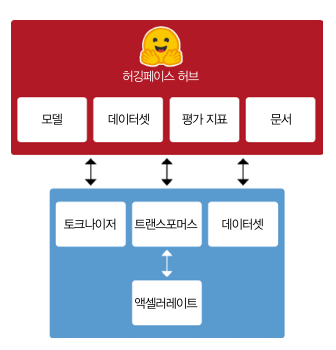


In [31]:
# 감성분석
# 테슬라에서 차량모양이 있는 트위터 사진을공유 그 반응을 분석, 감정상태를 자동으로 인식하는 시스템을 만든다
# BERT 의 한종류인 DistilBERT모델  작고 가볍다는 장점, 대규모모델을 훈련 사전훈련된모델에서 체크포인트(checkpoint)변경

In [32]:
# 체크포인트 : 트랜스포머 아키텍처로 로드되는 일련의가중치
# 데이터셋->토크나이저->트랜스포머스->데이터셋

In [33]:
!pip install datasets

In [34]:
from datasets import list_datasets

In [35]:
all_datasets = list_datasets()
len(all_datasets), all_datasets[:10]

<ipython-input-35-ee25709861b7>:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


(74308,
 ['acronym_identification',
  'ade_corpus_v2',
  'adversarial_qa',
  'aeslc',
  'afrikaans_ner_corpus',
  'ag_news',
  'ai2_arc',
  'air_dialogue',
  'ajgt_twitter_ar',
  'allegro_reviews'])

In [36]:
from datasets import load_dataset
emotioins = load_dataset("emotion")
emotioins

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [37]:
train_ds = emotioins['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [38]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [39]:
train_ds.column_names

['text', 'label']

In [40]:
# 트윗과 감정

In [41]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [42]:
# train_ds의 데이터 타입은 아파치 애로우(Aparch Arrow)를 기반--> 파이썬보다 훨씬더 메모리를효율적으로 관리

In [43]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [44]:
train_ds['text'][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

In [45]:
# 데이터셋->데이터프레임
emotioins.set_format(type="pandas")
df = emotioins['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [46]:
# emotioins['train'].features['label'].int2str(1)
df['label_name'] = df['label'].apply(lambda x : emotioins['train'].features['label'].int2str(x))

In [47]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [48]:
# 클래스의 분포를 확인.. 편향된 데이터셋은 균형잡힌 데이터와 다른 처리법

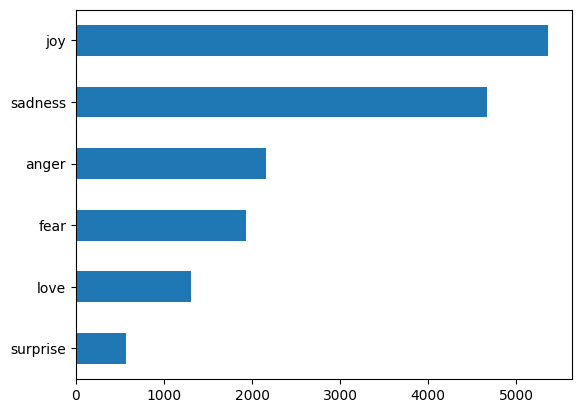

In [49]:
# 시각화를 통해서 빠르게 알아봅시다
import matplotlib.pyplot as plt
df['label_name'].value_counts(ascending=True).plot.barh()
plt.show()

In [50]:
# 불균형 데이터
# 오버샘플링 : 소스클래스를 랜덤하게 오버샘플
# 언더샘플링 : 다수클래스를 랜덤하게 언더샘플
# 더 많이 수집
# https://imbalanced-learn.org/stable/

In [51]:
# 트랜스퍼모델 : 최대 문맥크기(maximum context size)
# DistilBERT 512토큰  토큰=단어

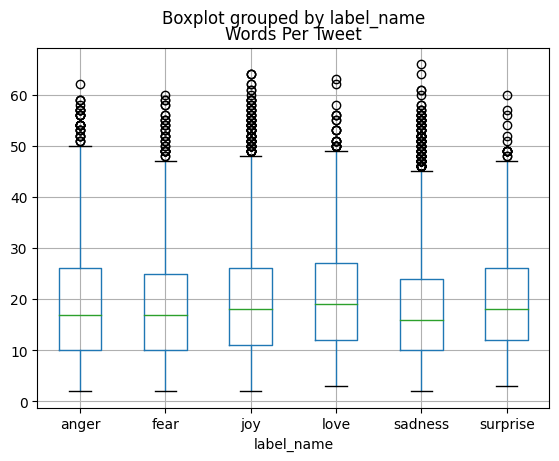

In [52]:
# 트윗당 단어의 분포
# df['text'].apply(lambda x : len(x.split()))
df['Words Per Tweet'] =  df['text'].str.split().apply(len)
df.boxplot("Words Per Tweet",by='label_name')
plt.show()

In [53]:
# 원시데이터의 포멧을 초기화
emotioins.reset_format()

In [54]:
# 텍스트에서 토큰으로
# 토큰화 전략.  문자 토근화, 단어 토큰화에대해서 알아보고
# DistilBERT에서 사용하는 토크나이저

In [55]:
# 문자토큰화
text = "Tokenizing text is a core task of NLP"
tokenizer_text = list(text)
print(tokenizer_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P']


In [56]:
# 수치화
token2idx = {ch:idx for idx, ch in enumerate( sorted(set(tokenizer_text)) )}
print(token2idx)

{' ': 0, 'L': 1, 'N': 2, 'P': 3, 'T': 4, 'a': 5, 'c': 6, 'e': 7, 'f': 8, 'g': 9, 'i': 10, 'k': 11, 'n': 12, 'o': 13, 'r': 14, 's': 15, 't': 16, 'x': 17, 'z': 18}


In [57]:
# 이걸 가지고 어휘사전(vocabray) 에 있는 문자를 정수로 바꾸는 매핑 딕셔너리
input_ids = [token2idx[token] for token in tokenizer_text]
print(input_ids)

[4, 13, 11, 7, 12, 10, 18, 10, 12, 9, 0, 16, 7, 17, 16, 0, 10, 15, 0, 5, 0, 6, 13, 14, 7, 0, 16, 5, 15, 11, 0, 13, 8, 0, 2, 1, 3]


In [58]:
# input_ids를 웟핫으로 변경
# 파이토치로 텐서로변경한다음 ont_hot()함수를 이용해서 원-핫인코딩
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids,num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([37, 19])

In [59]:
one_hot_encodings

tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

In [60]:
input_ids[0],one_hot_encodings[0]

(tensor(4), tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [61]:
# 문자수준의 토큰화는 텍스트의 구조를 무시하고 전체문자열을 문자 스트림으로 처리
# 철자 오류나 희귀한단어를 처리하는데 유리,  - 이런 문자수준의 토큰화는 거의 사용안함
# 단어토큰화 : 텍스트의 일부 구조가 유지되는 방법

In [62]:
# 가장 간단한 단어토큰화는 공백을 사용해서 분리 split
tokenized_text = text.split()
tokenized_text

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP']

In [63]:
# 각 단어를 하나의 id에 매핑-->문제점 : 구두점이 고려되지 않아서 NLP .이 하나의 토큰으로 처리
# 어휘사전을 도입해서.. 구분.. 어휘사전에 없는 단어 UNK(unknown)으로 분리
# 문자토큰화와 단어토큰화의 절충안... 부분단어 토큰화(subword tokenization)

In [64]:
# 트랜스포머 사전훈련된 모델에 연관된 토크나이져 빠르게 로드하는 AutoTokenizer

In [65]:
# 자동로드
from transformers import AutoTokenizer
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)  # 이 방법은 빠르게 로드....

In [66]:
# 수동 로드
from transformers import DistilBertTokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [67]:
# 토크나이저 동작확인
encoded_text =  tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [68]:
# 다시 토큰으로변환
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(text),print(tokens)

Tokenizing text is a core task of NLP
['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '[SEP]']


(None, None)

In [69]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp [SEP]


In [70]:
tokenizer.vocab_size

30522

In [71]:
# 최대 문맥의 길이
tokenizer.model_max_length

512

In [72]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [73]:
# 전체데이터셋 토큰화 하기
# 토큰화 함수 --- DatasetDict 객체 map()에 적용할 함수
def tokenize(batch):
  return tokenizer(batch['text'],padding=True,truncation=True)
# padding=True  배치데이터중에서 가장 긴 샘플크기에 맞춰샘플을 0으로 패딩
# truncation=True 모델의 최대문맥 크기에 맞춰서 샘플을 잘나냄

In [74]:
emotioins['train'][:2]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'],
 'label': [0, 0]}

In [75]:
print(tokenize(emotioins['train'][:2]))

# {'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  # [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040,
  #  14977, 1998, 2003, 8300, 102]],
  #  'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  #   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


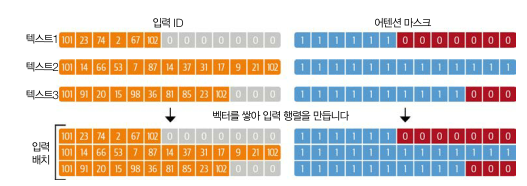

In [76]:
emotions_encoded =  emotioins.map(tokenize,batched=True, batch_size=None)
# batch_size=None 전체 데이터셋이 하나의 배치로 tokenize()함수에 적용

In [77]:
# 'input_ids', 'attention_mask' 두개가 새롭게 생성
emotions_encoded['train']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 16000
})

In [78]:
# 텍스트 분류 모델 훈련
# DistilBERT는 인코딩기반의 모델  그 모델 구조는 다음과 같다

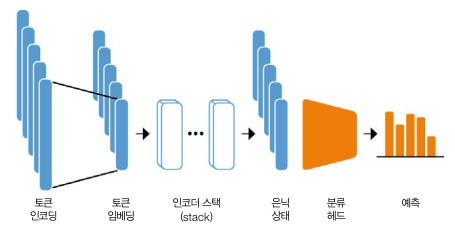

In [79]:
# 특성 추출
# 사전 훈련된 모델을 수정하지 않고 은닉상태 특성으로  사용해분류 모델을 훈련

# 미세 튜닝
# 사전 훈련된 모델의 파라메터도 업데이트하기 위해 전체 모델을 엔드- 투 - 엔드로 훈련

In [80]:
# 트랜스포머를 특성 추출기로 사용

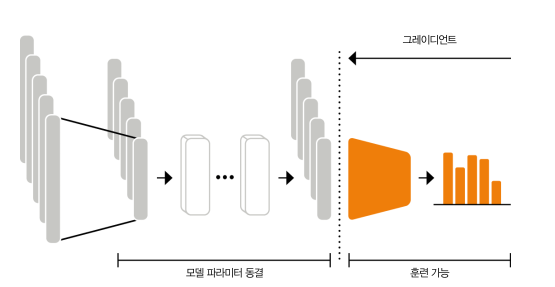

In [81]:
# 훈련하는동안 바디의 가중치를 동결하고 은닉상태를 분류모델의 특성으로 사용
# 작거나 얕은모델을 빠르게 훈련한다는 장점
# 이때 훈련되는 모델은  신경망 분류층이거나 랜덤포레스트같이 그레이디언트에 의존하지 않는 기법
# 은닉상태를 한번만 미리 계산하면 되므로 gpu를 사용하지 못할때 특히 편리

In [82]:
# 트랜스포머의 자동 클래스중에 하나인 AutoModel을 사용
from transformers import AutoModel
model_ckpt = 'distilbert-base-uncased'
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [83]:
# 마지막 은닉상태 추출
# 문자열을 인코딩하고 토큰을 파이토치 텐서로 변환
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(inputs['input_ids'].size())  #[batch_size, n_tokens]
# 인코딩을 텐서로 준비완료   모델에 있는 장치로 옮겨서 입력으로 전달
inputs = {k:v.to(device) for k, v in inputs.items()}
print(inputs)

with torch.no_grad():
  outputs = model(**inputs)
print(outputs)  # 마지막 은닉상태 한개를 반한

torch.Size([1, 6])
{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:0')}
BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [84]:
print(outputs.last_hidden_state.size())  # [batch_size, n_tokens, hidden_dim]
# 분류작업 [CLS]토큰에 연관되 은닉상태를 입력 특성으로 사용

torch.Size([1, 6, 768])


In [85]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [86]:
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names }
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  return {'hidden_state' :  last_hidden_state[:,0].cpu().numpy()}

In [87]:
# 모델은 텐서가 입력되기를 희망  torch 포멧으로 변경
emotions_encoded.set_format("torch", columns=['input_ids','attention_mask','label'])

In [88]:
emotions_hidden = emotions_encoded.map(extract_hidden_states,batched=True)

In [89]:
# batch size를 정하지 않아서 기본값인 batch_size = 1000이 사용
# extract_hidden_states() 함수를  사용했기 때문에 hidden_sate열이  생김
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [90]:
# 각 트윗에 대한 은닉상태를 얻었음 - 분류 모델을 훈련,  필요한게 특성행렬
# 특성 행렬 만들기

In [91]:
import numpy as np

x_train = np.array(emotions_hidden['train']['hidden_state'])
x_valid = np.array(emotions_hidden['validation']['hidden_state'] )
y_train = np.array(emotions_hidden['train']['label'] )
y_valid = np.array(emotions_hidden['validation']['label'] )
x_train.shape, x_valid.shape

((16000, 768), (2000, 768))

In [92]:
# 시각화 차수가 768 -> 시각화 불가능 , UMAP알고리즘  특성이 [0,1] 잘 동작
# minmaxscaler....

In [93]:
!pip install umap-learn

In [94]:
from umap import UMAP

In [95]:
from sklearn.preprocessing import MinMaxScaler

In [96]:
# 특성 스케일을 0,1 범위로 조정
x_scaled =  MinMaxScaler().fit_transform(x_train)
mapper = UMAP(n_components=2, metric='cosine').fit(x_scaled)

In [97]:
df_emb = pd.DataFrame(mapper.embedding_, columns=['x','y'])
df_emb['label'] = y_train
df_emb.head()

,x,y,label
0,4.482509,7.203855,0
1,-2.600641,6.929296,0
2,5.300582,3.869014,3
3,-2.212824,4.913257,2
4,-3.063374,4.878272,3


In [110]:
emotioins['train'].features['label'].names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

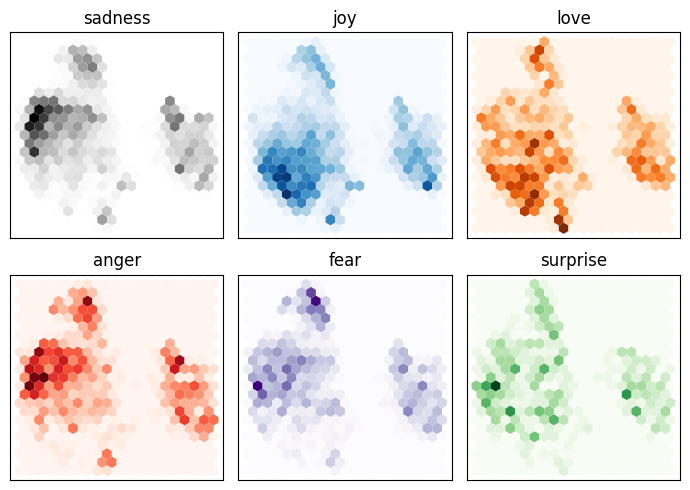

In [122]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(2,3,figsize = (7,5))
axes = axes.flatten()
labels = emotioins['train'].features['label'].names
cmaps = ['Greys','Blues','Oranges','Reds','Purples','Greens']
for i, (label,cmap) in enumerate( zip(labels,cmaps)):
  df_emb_sub =  df_emb.query(f"label=={i}")
  axes[i].hexbin(df_emb_sub['x'], df_emb_sub['y'], cmap=cmap,gridsize=20,linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]),axes[i].set_yticks([])
plt.tight_layout()
plt.show()
